In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import sys
import pathlib

In [5]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import the local package 

In [6]:
sys.path.append('../../')

In [7]:
from src import plot, utils, GPM, geo

### first step, we update the local GPM-IMERG dataset on disk, which is in by default `/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP`

In [8]:
GPM.update()

Last downloaded file in /home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP is GPM_IMERG_daily.v06.2021.05.02.nc

trying to download GPM_IMERG_daily.v06.2021.05.03.nc in /home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP

! file size for input file 3B-DAY-L.MS.MRG.3IMERG.20210503-S000000-E235959.V06.nc4 is too small, netcdf file GPM_IMERG_daily.v06.2021.05.03.nc is not yet available to download from https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGDL.06/2021/05



In [9]:
ndays = 30

In [10]:
dpath_realtime = CWD.parents[5] / 'ops/data/GPM_IMERG/daily/extended_SP'

In [11]:
lfiles = GPM.get_files_list(dpath = dpath_realtime, ndays=ndays, lag=2)

In [12]:
dset = GPM.make_dataset(lfiles, ndays=ndays)

In [13]:
dset

,Array,Chunk
Bytes,33.12 MB,1.10 MB
Shape,"(30, 300, 460)","(1, 300, 460)"
Count,90 Tasks,30 Chunks
Type,float64,numpy.ndarray


### get the last date and the number of days in the dataset, which are created automatically as global attributes in the dataset 

In [14]:
last_date, ndays_dset  = GPM.get_attrs(dset)

### calculate the rainfall accumulation over the past N days 

In [15]:
dset_accum = GPM.calculate_realtime_accumulation(dset)

### get the rain days stats: number of rain days (threshold = 1 mm/day), number of dry days, and number of days since last rain

In [16]:
dset_ndays = GPM.get_rain_days_stats(dset)

### get the climatology, for the calculation of the anomalies 

In [17]:
clim = GPM.get_climatology(dpath=dpath_realtime, ndays=ndays, date=last_date)

### calculates the anomalies and the percentages of scores, and insert the resulting variables (`anoms` and `pctscore`) in the dataset 

In [18]:
dset_accum = GPM.calc_anoms_and_pctscores(dset_accum, clim)

In [19]:
dset_accum

<xarray.Dataset>
Dimensions:           (lat: 300, lon: 460, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2021-05-01
  * lon               (lon) float64 125.1 125.4 125.6 ... 239.4 239.6 239.9
  * lat               (lat) float64 -49.88 -49.62 -49.38 ... 24.38 24.62 24.88
Data variables:
    precipitationCal  (time, lat, lon) float64 153.5 151.0 133.4 ... 2.393 2.467
    pctscore          (time, lat, lon) float64 72.63 61.05 51.58 ... 58.95 53.68
    anoms             (time, lat, lon) float64 24.3 18.69 ... -2.398 -1.845
Attributes:
    BeginDate:       2021-04-02
    BeginTime:       00:00:00.000Z
    EndDate:         2021-04-02
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2021-04-02T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20210402-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2021-04-03T15:22:18.108Z
    ndays:           30
    last_day:        2021-05-01

### get the EEZs for each country, and a dissolved version for the mask 

In [20]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes='/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/')

### insert the mask in each dataset 

In [21]:
dset_accum = geo.make_mask_from_gpd(dset_accum, merged_EEZs, subset=True, mask_name='EEZ')

In [22]:
dset_ndays = geo.make_mask_from_gpd(dset_ndays, merged_EEZs, subset=True, mask_name='EEZ')

In [23]:
dset_accum

<xarray.Dataset>
Dimensions:           (lat: 220, lon: 439, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2021-05-01
  * lon               (lon) float64 129.4 129.6 129.9 ... 238.4 238.6 238.9
  * lat               (lat) float64 -30.88 -30.62 -30.38 ... 23.38 23.62 23.88
Data variables:
    precipitationCal  (time, lat, lon) float64 5.2 6.207 7.636 ... 0.7359 0.8144
    pctscore          (time, lat, lon) float64 5.263 5.263 5.263 ... 15.79 24.21
    anoms             (time, lat, lon) float64 -36.28 -34.15 ... -3.858 -3.25
    EEZ               (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    BeginDate:       2021-04-02
    BeginTime:       00:00:00.000Z
    EndDate:         2021-04-02
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2021-04-02T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20210402-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2021-04-03T15:22:18.108Z
    ndays:           30
    last_day:        2021-05-01

### Plots the precipitation anomalies 

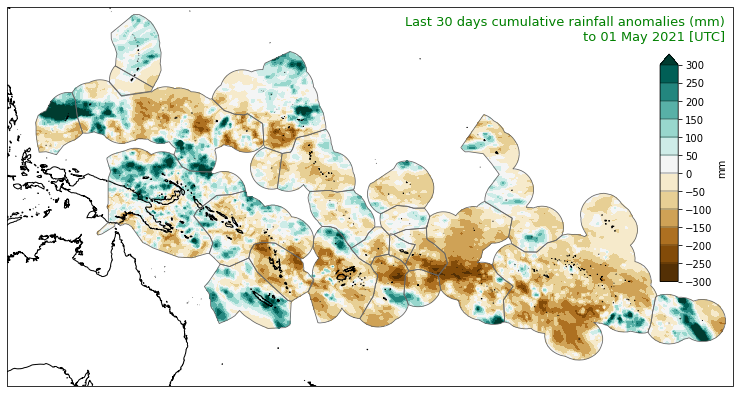

In [24]:
plot.map_precip_anoms(dset_accum, mask='EEZ', close=False, geoms=EEZs)

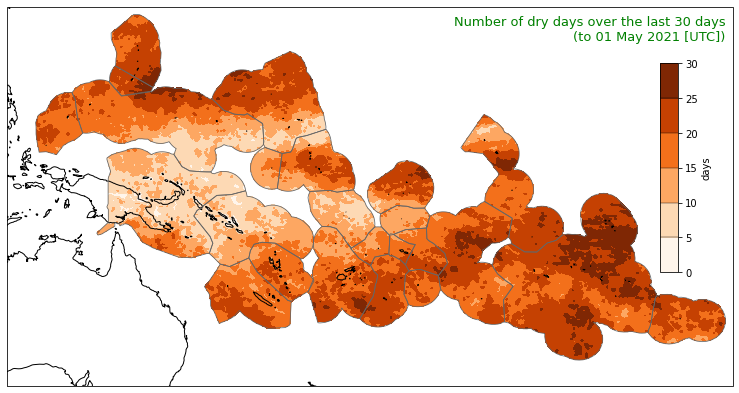

In [25]:
plot.map_dry_days_Pacific(dset_ndays, mask='EEZ', geoms=EEZs, close=False)